In [1]:
import numpy as np 
import sacc
import matplotlib.pyplot as plt
import os
from mflike import PlikMFLike, MFLike
from cobaya.yaml import yaml_load_file
import camb
col = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
linestyle = ['solid','dashed','dotted','dashdot']
fmt_list = ['o', 'X', "^",'s']

In [2]:
### data

DIR_data = "/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/highL_2015/data/"

def to_dl(ell):
    if type(ell) == list:
        ell = np.asarray(ell)
    return ell*(ell+1)/2/np.pi

ells_acte = [1,2,3] 
dls_acte = [1,2,3]
err_acte = [1,2,3]
# Read data from files (replace these with your actual file paths)
ells_acte[0], dls_acte[0], err_acte[0] = np.loadtxt(DIR_data + 'data_act/equa/spectrum_148x148.dat',unpack=True)
ells_acte[1], dls_acte[1], err_acte[1] = np.loadtxt(DIR_data + 'data_act/equa/spectrum_148x220.dat',unpack=True)
ells_acte[2], dls_acte[2], err_acte[2] = np.loadtxt(DIR_data + 'data_act/equa/spectrum_220x220.dat',unpack=True)

ells_acts = [1,2,3] 
dls_acts = [1,2,3]
err_acts = [1,2,3]
# Read data from files (replace these with your actual file paths)
ells_acts[0], dls_acts[0], err_acts[0] = np.loadtxt(DIR_data + 'data_act/south/spectrum_148x148.dat',unpack=True)
ells_acts[1], dls_acts[1], err_acts[1] = np.loadtxt(DIR_data + 'data_act/south/spectrum_148x220.dat',unpack=True)
ells_acts[2], dls_acts[2], err_acts[2] = np.loadtxt(DIR_data + 'data_act/south/spectrum_220x220.dat',unpack=True)

for i in range(3):
    dls_acte[i] = to_dl(ells_acte[i]) * dls_acte[i]
    dls_acts[i] = to_dl(ells_acts[i]) * dls_acts[i]
    err_acte[i] = to_dl(ells_acte[i]) * err_acte[i]
    err_acts[i] = to_dl(ells_acts[i]) * err_acts[i]
    
freqs_spt = ["90x90", "90x150", "90x220", "150x150", "150x220", "220x220"]
freqs_act = ["148x148", "148x218", "218x218"]
def read_spt_bandpower_george():
    fname = "/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/highL_2015/data/data_spt/spt_bandpower.dat"
    ells = []
    Dls = []
    Dls_err = []
    i = -1
    with open(fname, 'r') as f:
        lines = f.readlines()
        for line in lines:
            ell, dl, dls_err = line.split()
            if int(ell) == 2106:
                i+=1
                ells.append([])
                Dls.append([])
                Dls_err.append([])
            ells[i].append(int(ell))
            Dls[i].append(float(dl))
            Dls_err[i].append(float(dls_err))
    for i in range(len(ells)):
        ells[i] = np.asarray(ells[i])
        Dls[i] = np.asarray(Dls[i])
        Dls_err[i] = np.asarray(Dls_err[i])
    return ells, Dls, Dls_err

def read_spt_bandpower_reichardt():
    fname = "/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/DR6_fgmodels/notebooks/Reichardt_bps.dat"
    ells = []
    Dls = []
    Dls_err = []
    for i, fr in enumerate(freqs_spt):
        ls, dls, err = np.loadtxt(fname, usecols=(1,2+i*2,2*i+3), unpack=True)
        if i == 0 :
            ells.append(ls[:-2])
            Dls.append(dls[:-2])
            Dls_err.append(err[:-2])
        else:
            ells.append(ls)
            Dls.append(dls)
            Dls_err.append(err)
    return ells, Dls, Dls_err

In [25]:
### defs

def read_min(fname):
    data_dict = {}
    with open(fname, 'r') as file:
        lines = file.readlines()[3:]
        i=0
        i_fixed =0
        fixed=False
        for line in lines:
            i+=1
#             if not line.strip() and fixed == False:  # Check for empty line
                
            parts = line.split()
            if len(parts) >= 3:
                key = parts[2]
                value = parts[1]
                data_dict[key] = float(value)
            elif fixed==False:
                i_fixed = i-1
                fixed=True
                
    return data_dict, i_fixed

def read_chi_sqr(fname):
    with open(fname, 'r') as file:
        line = file.readlines()[1]
        chi_sqr = float(line.split('=')[-1])
    return chi_sqr

def cosmo_params(params):
    cosmo_pars = {}
    for key in ["H0","ns", "ombh2", "omch2", "tau"]:
        cosmo_pars[key] = params[key]
    cosmo_pars["logA"] = {"value": params["logA"], "drop": True}
    cosmo_pars["As"] = {"value": "lambda logA: 1e-10*np.exp(logA)"}
    return cosmo_pars

def get_cls_dict(params):
    camb_cosmo = {k: v for k, v in cosmo_params(params).items() if k not in ["logA", "As"]}
    camb_cosmo.update({"As": 1e-10 * np.exp(cosmo_params(params)["logA"]["value"]),"lmax": 6000,"lens_potential_accuracy": 1})
    pars = camb.set_params(**camb_cosmo)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")
    cl_dict = {k: powers["total"][:, v] for k, v in {"tt": 0, "ee": 1, "te": 3, "bb": 2}.items()}
    cl_dict['tt'][6000:] = 0.
    cl_dict['ell'] = np.linspace(0,6000,6001).astype('int')
    return cl_dict

def get_dls_obs_highL(directory, chain):
    DIR = "/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/DR6_fgmodels"
    os.chdir(os.path.join(DIR, directory))
    params, nparams = read_min(os.path.join("../outputs/chains_2", f"{chain}.minimum"))
    info_from_yaml = yaml_load_file("likelihood_mflike_highL.yaml")
    my_mflike = MFLike(info_from_yaml['mflike.MFLike'])
    cl_dict = get_cls_dict(params)
    Dls = {}
    for s, _ in my_mflike.lcuts.items():
        dl = np.zeros_like(my_mflike.l_bpws)
        dl[:my_mflike.lmax_theory+1] = cl_dict[s][:my_mflike.lmax_theory+1]
        Dls[s] = dl
    DlsObs = my_mflike.ThFo.get_modified_theory(Dls, **params)
    component_list = my_mflike.ThFo.fg_component_list
    fg_dict = my_mflike.ThFo._get_foreground_model(**params)
    ps_vec = my_mflike._get_power_spectra(Dls, **params)
    delta = my_mflike.data_vec - ps_vec
    dof = len(my_mflike.data_vec) - nparams
    chi_2 = {}
    DlsObs_window = {}
    leff = {}
    for m in my_mflike.spec_meta:
        ind = m['ids']
        row_mesh, column_mesh = np.meshgrid(ind,ind, indexing='ij')
        w = m["bpw"].weight.T
        leff["tt", m["t1"], m["t2"]] = m["leff"]
        DlsObs_window["tt", m["t1"], m["t2"]] = w @ DlsObs["tt", m["t1"], m["t2"]]
        chi_2["tt", m["t1"], m["t2"]] = delta[ind] @ my_mflike.inv_cov[row_mesh, column_mesh] @ delta[ind] 
    DlsObs_contribution = {}
    for key in component_list.keys():
        exp = key[0]
        cl = key[1]
        for component in component_list[key]:
            for m in my_mflike.spec_meta:
                if m["t1"][:4] == exp and m["t2"][:4] == exp:
                    DlsObs_contribution[cl,m["t1"], m["t2"], component] = fg_dict[cl, component, m["t1"],m["t2"]]
                    if exp == "sptr" and 'original' in directory: 
                        DlsObs_contribution[cl,m["t1"], m["t2"], "tsz_and_cib"] = fg_dict[cl, 'tsz', m["t1"],m["t2"]] + fg_dict[cl, 'cibc_1H', m["t1"],m["t2"]]+ fg_dict[cl, 'cibc_2H', m["t1"],m["t2"]] + fg_dict[cl, 'tszxcib_spt', m["t1"],m["t2"]]
            
    return my_mflike.l_bpws, DlsObs,DlsObs_contribution, component_list, leff, DlsObs_window, chi_2

def get_dls_params(directory, params): 
    info_from_yaml = yaml_load_file(os.path.join("../", directory,"likelihood_mflike_highL.yaml"))
    my_mflike = MFLike(info_from_yaml['mflike.MFLike'])
    camb_cosmo = {k: v for k, v in cosmo_params(params).items() if k not in ["logA", "As"]}
    camb_cosmo.update({"As": 1e-10 * np.exp(cosmo_params(params)["logA"]["value"]),"lmax": 6000,"lens_potential_accuracy": 1})
    pars = camb.set_params(**camb_cosmo)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")
    cl_dict = {k: powers["total"][:, v] for k, v in {"tt": 0, "ee": 1, "te": 3, "bb": 2}.items()}
    cl_dict['tt'][6000:] = 0.
    cl_dict['ell'] = np.linspace(0,6000,6001).astype('int')
    Dls = {}
    for s, _ in my_mflike.lcuts.items():
        dl = np.zeros_like(my_mflike.l_bpws)
        dl[:my_mflike.lmax_theory+1] = cl_dict[s][:my_mflike.lmax_theory+1]
        Dls[s] = dl
    DlsObs = my_mflike.ThFo.get_modified_theory(Dls, **params)
    component_list = my_mflike.ThFo.fg_component_list
    fg_dict = my_mflike.ThFo._get_foreground_model(**params)
    DlsObs_contribution = {}
    for key in component_list.keys():
        exp = key[0]
        cl = key[1]
        for component in component_list[key]:
            for m in my_mflike.spec_meta:
                if m["t1"][:4] == exp and m["t2"][:4] == exp:
                    DlsObs_contribution[cl,m["t1"], m["t2"], component] = fg_dict[cl, component, m["t1"],m["t2"]]
    return my_mflike.l_bpws, DlsObs, DlsObs_contribution, component_list


## Plots all

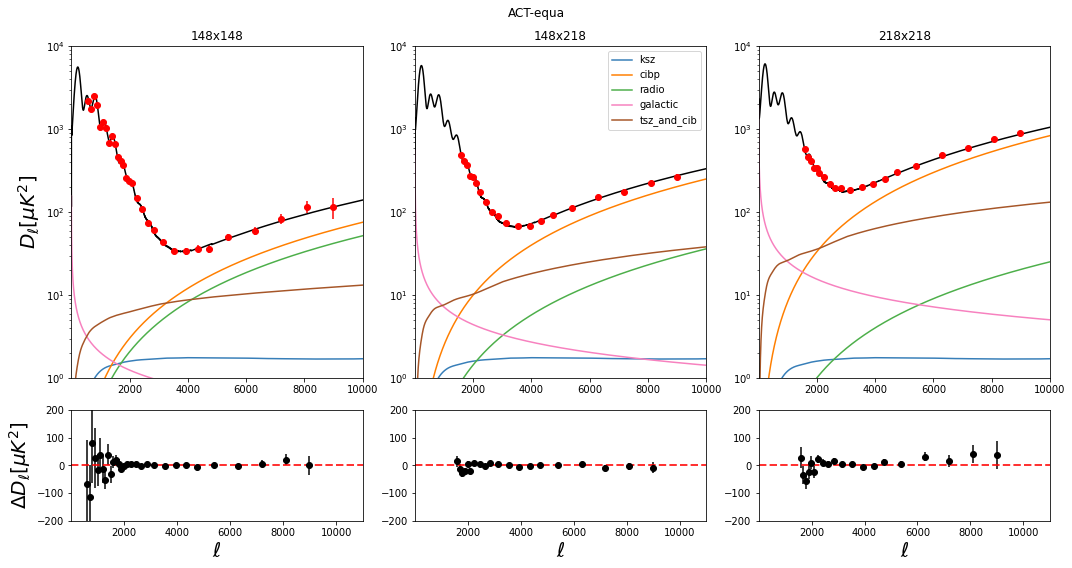

In [40]:
### ACT-Equa

# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_acte[0], dls_acte[0], yerr=err_acte[0], fmt='o', c='r')
axs[0, 1].errorbar(ells_acte[1], dls_acte[1], yerr=err_acte[1], fmt='o', c='r')
axs[0, 2].errorbar(ells_acte[2], dls_acte[2], yerr=err_acte[2], fmt='o', c='r')

directory_list = ["DR6_modelling/MBAC_reichardt_plik"]
chain_list = ["MBAC_reichardt_plik_betar_betacp_fixedcosmo"]


txt_0 = ''
txt_1 = ''
txt_2 = ''

for i_model in range(len(directory_list)):
    label = directory_list[i_model].split('/')[0]
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory_list[i_model], chain_list[i_model])
    axs[0, 0].plot(ell, DlsObs["tt", "acte_148", "acte_148"], ls=linestyle[i_model], c='k', label=label)
    axs[0, 1].plot(ell, DlsObs["tt", "acte_148", "acte_220"], c='k')
    axs[0, 2].plot(ell, DlsObs["tt", "acte_220", "acte_220"], c='k')
#     txt_0 += fmt_list[i_model] + ' ' + label[:3] + " {:.3f}".format(chi_2["tt", "acte_148", "acte_148"]) + ', '
    txt_1 += fmt_list[i_model] + ' ' + label[:3] + " {:.3f}".format(chi_2["tt", "acte_148", "acte_220"]) + ', '
    txt_2 += fmt_list[i_model] + ' ' + label[:3] + " {:.3f}".format(chi_2["tt", "acte_220", "acte_220"]) + ', '

    
    for j_c, c in enumerate(cmp_list['acte', 'tt']):
        axs[0, 0].plot(ell, cmp["tt", "acte_148", "acte_148", c], ls=linestyle[i_model], c=col[j_c])
        if i_model==0:
            axs[0, 1].plot(ell, cmp["tt", "acte_148", "acte_220", c], ls=linestyle[i_model], c=col[j_c], label=c)
        else: 
            axs[0, 1].plot(ell, cmp["tt", "acte_148", "acte_220", c], ls=linestyle[i_model], c=col[j_c])
        axs[0, 2].plot(ell, cmp["tt", "acte_220", "acte_220", c], ls=linestyle[i_model], c=col[j_c])
        

    axs[1, 0].errorbar(ells_acte[0], dls_acte[0] - DlsObs_window["tt", "acte_148", "acte_148"], yerr=err_acte[0], fmt=fmt_list[i_model], c='k')
    axs[1, 1].errorbar(ells_acte[1], dls_acte[1] - DlsObs_window["tt", "acte_148", "acte_220"], yerr=err_acte[1], fmt=fmt_list[i_model], c='k')
    axs[1, 2].errorbar(ells_acte[2], dls_acte[2] - DlsObs_window["tt", "acte_220", "acte_220"], yerr=err_acte[2], fmt=fmt_list[i_model], c='k')

# axs[1, 0].text(0.95, 0.01, txt_0 ,verticalalignment='bottom',horizontalalignment='right',
#                transform=axs[1,0].transAxes,bbox={'facecolor':'white', 'pad': 5}, fontsize=13)
# axs[1, 1].text(0.95, 0.01, txt_1 ,verticalalignment='bottom',horizontalalignment='right',
#                transform=axs[1,1].transAxes,bbox={'facecolor':'white', 'pad': 5}, fontsize=13)
# axs[1, 2].text(0.95, 0.01, txt_2 ,verticalalignment='bottom',horizontalalignment='right',
#                transform=axs[1,2].transAxes,bbox={'facecolor':'white', 'pad': 5}, fontsize=13)

# Add titles and labels
# axs[0,0].legend()
axs[0,1].legend()
for i in range(3):
    axs[1, i].set_xlabel('$\ell$', fontsize=20)
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,11000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[0, i].set_xlim(2, 1e4)
    axs[1, i].set_ylim(-200, 200)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2, 11000)
    axs[0,i].set_title(f"{freqs_act[i]}")
    
axs[0,0].set_ylabel('$D_\ell [\mu K^2]$', fontsize=20)
axs[1,0].set_ylabel('$\Delta D_\ell [\mu K^2]$', fontsize=20)
plt.suptitle("ACT-equa")
# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join("/Users/benjaminberingue/Documents/Research/Presentation/AIG talk Nov 21/",
            "residuals_acte.png"))
plt.show()


In [ ]:
###ACT - South


# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_acts[0], dls_acts[0], yerr=err_acts[0], fmt='o', c='r')
axs[0, 1].errorbar(ells_acts[1], dls_acts[1], yerr=err_acts[1], fmt='o', c='r')
axs[0, 2].errorbar(ells_acts[2], dls_acts[2], yerr=err_acts[2], fmt='o', c='r')

directory_list = ["DR6_modelling/MBAC_reichardt_plik", "DR6_modelling/MBAC_reichardt_plik", "DR6_modelling/MBAC_reichardt_plik"]
chain_list = ["MBAC_reichardt_plik_betar_betacp_fixedcosmo", "MBAC_reichardt_plik_betar_fixedcosmo", "MBAC_reichardt_plik_fixedcosmo"]

txt_0 = ''
txt_1 = ''
txt_2 = ''

for i_model in range(len(directory_list)):
    label = directory_list[i_model].split('/')[0]
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2, chi_tot = get_dls_obs_highL(directory_list[i_model], chain_list[i_model])
    print(i_model, chi_tot)
    axs[0, 0].plot(ell, DlsObs["tt", "acts_148", "acts_148"], ls=linestyle[i_model], c='k', label=label)
    axs[0, 1].plot(ell, DlsObs["tt", "acts_148", "acts_220"], c='k')
    axs[0, 2].plot(ell, DlsObs["tt", "acts_220", "acts_220"], c='k')
    txt_0 += fmt_list[i_model] + ' ' + label[:3] + " {:.3f}".format(chi_2["tt", "acts_148", "acts_148"]) + ', '
    txt_1 += fmt_list[i_model] + ' ' + label[:3] + " {:.3f}".format(chi_2["tt", "acts_148", "acts_220"]) + ', '
    txt_2 += fmt_list[i_model] + ' ' + label[:3] + " {:.3f}".format(chi_2["tt", "acts_220", "acts_220"]) + ', '

    
#     for j_c, c in enumerate(cmp_list['acte', 'tt']):
#         axs[0, 0].plot(ell, cmp["tt", "acte_148", "acte_148", c], ls=linestyle[i_model], c=col[j_c])
#         if i_model==0:
#             axs[0, 1].plot(ell, cmp["tt", "acte_148", "acte_220", c], ls=linestyle[i_model], c=col[j_c], label=c)
#         else: 
#             axs[0, 1].plot(ell, cmp["tt", "acte_148", "acte_220", c], ls=linestyle[i_model], c=col[j_c])
#         axs[0, 2].plot(ell, cmp["tt", "acte_220", "acte_220", c], ls=linestyle[i_model], c=col[j_c])
        

    axs[1, 0].errorbar(ells_acts[0], dls_acts[0] - DlsObs_window["tt", "acts_148", "acts_148"], yerr=err_acts[0], fmt=fmt_list[i_model], c='k')
    axs[1, 1].errorbar(ells_acts[1], dls_acts[1] - DlsObs_window["tt", "acts_148", "acts_220"], yerr=err_acts[1], fmt=fmt_list[i_model], c='k')
    axs[1, 2].errorbar(ells_acts[2], dls_acts[2] - DlsObs_window["tt", "acts_220", "acts_220"], yerr=err_acts[2], fmt=fmt_list[i_model], c='k')

axs[1, 0].text(0.95, 0.01, txt_0 ,verticalalignment='bottom',horizontalalignment='right',
               transform=axs[1,0].transAxes,bbox={'facecolor':'white', 'pad': 5}, fontsize=13)
axs[1, 1].text(0.95, 0.01, txt_1 ,verticalalignment='bottom',horizontalalignment='right',
               transform=axs[1,1].transAxes,bbox={'facecolor':'white', 'pad': 5}, fontsize=13)
axs[1, 2].text(0.95, 0.01, txt_2 ,verticalalignment='bottom',horizontalalignment='right',
               transform=axs[1,2].transAxes,bbox={'facecolor':'white', 'pad': 5}, fontsize=13)

# Add titles and labels
axs[0,0].legend()
for i in range(3):
    axs[1, i].set_xlabel('x')
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,11000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[0, i].set_xlim(2, 1e4)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2, 11000)
    axs[0,i].set_title(f"{freqs_act[i]}")
    
    
plt.suptitle("ACT-south")
# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join("/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/DR6_fgmodels/figures",
            "residuals_acts.png"))
plt.show()


In [ ]:
### SPT-George 

# Read data from files (replace these with your actual file paths)
ells_spt, dls_spt, err_spt = read_spt_bandpower_george()
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_spt[0], dls_spt[0], yerr=err_spt[0], fmt='o', c='r')
axs[0, 1].errorbar(ells_spt[1], dls_spt[1], yerr=err_spt[1], fmt='o', c='r')
axs[0, 2].errorbar(ells_spt[2], dls_spt[2], yerr=err_spt[2], fmt='o', c='r')

ell, DlsObs_highL, leff, DlsObs_window_highL = get_dls_obs_highL("highL_plik", "plik_highL_prior")
axs[0, 0].plot(ell, DlsObs_highL["tt", "sptg_90", "sptg_90"], c='k', label="highL")
axs[0, 1].plot(ell, DlsObs_highL["tt", "sptg_90", "sptg_150"], c='k')
axs[0, 2].plot(ell, DlsObs_highL["tt", "sptg_90", "sptg_220"], c='k')

ell, DlsObs_dr6, leff, DlsObs_window_dr6 = get_dls_obs_highL("highL_plik_commonSZCIB_fixedTc_dr6poisson", "plik_highL_bandeff")
axs[0, 0].plot(ell, DlsObs_dr6["tt", "sptg_90", "sptg_90"], c='b', label="DR6 modelling")
axs[0, 1].plot(ell, DlsObs_dr6["tt", "sptg_90", "sptg_150"], c='b')
axs[0, 2].plot(ell, DlsObs_dr6["tt", "sptg_90", "sptg_220"], c='b')

ell, DlsObs_common, leff, DlsObs_window_common = get_dls_obs_highL("highL_plik_commonSZCIB_fixedTc", "plik_highL_bandeff")
axs[0, 0].plot(ell, DlsObs_common["tt", "sptg_90", "sptg_90"], c='g', label="common templates")
axs[0, 1].plot(ell, DlsObs_common["tt", "sptg_90", "sptg_150"], c='g')
axs[0, 2].plot(ell, DlsObs_common["tt", "sptg_90", "sptg_220"], c='g')

# Plot residuals
axs[1, 0].errorbar(ells_spt[0], dls_spt[0] - DlsObs_window_highL["tt", "sptg_90", "sptg_90"], yerr=err_spt[0], fmt='o', c='k')
axs[1, 1].errorbar(ells_spt[1], dls_spt[1] - DlsObs_window_highL["tt", "sptg_90", "sptg_150"], yerr=err_spt[1], fmt='o', c='k')
axs[1, 2].errorbar(ells_spt[2], dls_spt[2] - DlsObs_window_highL["tt", "sptg_90", "sptg_220"], yerr=err_spt[2], fmt='o', c='k')

axs[1, 0].errorbar(ells_spt[0], dls_spt[0] - DlsObs_window_dr6["tt", "sptg_90", "sptg_90"], yerr=err_spt[0], fmt='o', c='b')
axs[1, 1].errorbar(ells_spt[1], dls_spt[1] - DlsObs_window_dr6["tt", "sptg_90", "sptg_150"], yerr=err_spt[1], fmt='o', c='b')
axs[1, 2].errorbar(ells_spt[2], dls_spt[2] - DlsObs_window_dr6["tt", "sptg_90", "sptg_220"], yerr=err_spt[2], fmt='o', c='b')

axs[1, 0].errorbar(ells_spt[0], dls_spt[0] - DlsObs_window_common["tt", "sptg_90", "sptg_90"], yerr=err_spt[0], fmt='o', c='g')
axs[1, 1].errorbar(ells_spt[1], dls_spt[1] - DlsObs_window_common["tt", "sptg_90", "sptg_150"], yerr=err_spt[1], fmt='o', c='g')
axs[1, 2].errorbar(ells_spt[2], dls_spt[2] - DlsObs_window_common["tt", "sptg_90", "sptg_220"], yerr=err_spt[2], fmt='o', c='g')

# Add titles and labels
axs[0,0].legend()
for i in range(3):
#     axs[0, i].set_title(f'Data {i+1}')
#     axs[1, i].set_title(f'Residuals {i+1}')
    axs[1, i].set_xlabel('x')
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,11000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[0, i].set_xlim(2, 11000)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2, 11000)
    axs[0,i].set_title(f"{freqs_spt[i]}")
    
plt.suptitle("SPTg")
# Adjust layout
plt.tight_layout()
plt.savefig("../figures/residuals_sptg1.png")
# Show the plot
plt.show()

In [ ]:
### SPT-George 

# Read data from files (replace these with your actual file paths)
ells_spt, dls_spt, err_spt = read_spt_bandpower_george()
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_spt[3], dls_spt[3], yerr=err_spt[3], fmt='o', c='r')
axs[0, 1].errorbar(ells_spt[4], dls_spt[4], yerr=err_spt[4], fmt='o', c='r')
axs[0, 2].errorbar(ells_spt[5], dls_spt[5], yerr=err_spt[5], fmt='o', c='r')

ell, DlsObs_highL, leff, DlsObs_window_highL = get_dls_obs_highL("highL_plik", "plik_highL_prior")
axs[0, 0].plot(ell, DlsObs_highL["tt", "sptg_150", "sptg_150"], c='k', label="highL")
axs[0, 1].plot(ell, DlsObs_highL["tt", "sptg_150", "sptg_220"], c='k')
axs[0, 2].plot(ell, DlsObs_highL["tt", "sptg_220", "sptg_220"], c='k')

ell, DlsObs_dr6, leff, DlsObs_window_dr6 = get_dls_obs_highL("highL_plik_commonSZCIB_fixedTc_dr6poisson", "plik_highL_bandeff")
axs[0, 0].plot(ell, DlsObs_dr6["tt", "sptg_150", "sptg_150"], c='b', label="DR6 modelling")
axs[0, 1].plot(ell, DlsObs_dr6["tt", "sptg_150", "sptg_220"], c='b')
axs[0, 2].plot(ell, DlsObs_dr6["tt", "sptg_220", "sptg_220"], c='b')

ell, DlsObs_common, leff, DlsObs_window_common = get_dls_obs_highL("highL_plik_commonSZCIB_fixedTc", "plik_highL_bandeff")
axs[0, 0].plot(ell, DlsObs_common["tt", "sptg_150", "sptg_150"], c='g', label="Common templates")
axs[0, 1].plot(ell, DlsObs_common["tt", "sptg_150", "sptg_220"], c='g')
axs[0, 2].plot(ell, DlsObs_common["tt", "sptg_220", "sptg_220"], c='g')

# Plot residuals
axs[1, 0].errorbar(ells_spt[3], dls_spt[3] - DlsObs_window_highL["tt", "sptg_150", "sptg_150"], yerr=err_spt[3], fmt='o', c='k')
axs[1, 1].errorbar(ells_spt[4], dls_spt[4] - DlsObs_window_highL["tt", "sptg_150", "sptg_220"], yerr=err_spt[4], fmt='o', c='k')
axs[1, 2].errorbar(ells_spt[5], dls_spt[5] - DlsObs_window_highL["tt", "sptg_220", "sptg_220"], yerr=err_spt[5], fmt='o', c='k')

axs[1, 0].errorbar(ells_spt[3], dls_spt[3] - DlsObs_window_dr6["tt", "sptg_150", "sptg_150"], yerr=err_spt[3], fmt='o', c='b')
axs[1, 1].errorbar(ells_spt[4], dls_spt[4] - DlsObs_window_dr6["tt", "sptg_150", "sptg_220"], yerr=err_spt[4], fmt='o', c='b')
axs[1, 2].errorbar(ells_spt[5], dls_spt[5] - DlsObs_window_dr6["tt", "sptg_220", "sptg_220"], yerr=err_spt[5], fmt='o', c='b')

axs[1, 0].errorbar(ells_spt[3], dls_spt[3] - DlsObs_window_common["tt", "sptg_150", "sptg_150"], yerr=err_spt[3], fmt='o', c='g')
axs[1, 1].errorbar(ells_spt[4], dls_spt[4] - DlsObs_window_common["tt", "sptg_150", "sptg_220"], yerr=err_spt[4], fmt='o', c='g')
axs[1, 2].errorbar(ells_spt[5], dls_spt[5] - DlsObs_window_common["tt", "sptg_220", "sptg_220"], yerr=err_spt[5], fmt='o', c='g')

# Add titles and labels
axs[0,0].legend()
for i in range(3):
#     axs[0, i].set_title(f'Data {i+1}')
#     axs[1, i].set_title(f'Residuals {i+1}')
    axs[1, i].set_xlabel('x')
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,11000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[0, i].set_xlim(2, 11000)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2, 11000)
    axs[0,i].set_title(f"{freqs_spt[3+i]}")
    
plt.suptitle("SPTg")
# Adjust layout
plt.tight_layout()
plt.savefig("../figures/residuals_sptg2.png")
# Show the plot
plt.show()

In [ ]:
### SPT-Reichardt 

# Read data from files (replace these with your actual file paths)
ells_spt, dls_spt, err_spt = read_spt_bandpower_reichardt()
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_spt[0], dls_spt[0], yerr=err_spt[0], fmt='o', c='r')
axs[0, 1].errorbar(ells_spt[3], dls_spt[3], yerr=err_spt[3], fmt='o', c='r')
axs[0, 2].errorbar(ells_spt[5], dls_spt[5], yerr=err_spt[5], fmt='o', c='r')

directory_list = ["common_templates/MBAC_reichardt_plik","original/MBAC_reichardt_plik","DR6_modelling/MBAC_reichardt_plik"]
chain_list = ["MBAC_reichardt_Tdp97_fixedcosmo","MBAC_reichardt_fixedcosmo","MBAC_reichardt_betar_fixedcosmo"]

for i_model in range(len(directory_list)):
    label = directory_list[i_model].split('/')[0]
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory_list[i_model], chain_list[i_model])
    if i_model == 0 :
        cmp_list_freeze = cmp_list
    axs[0, 0].plot(ell, DlsObs["tt", "sptr_90", "sptr_90"], ls=linestyle[i_model], c='k', label=label)
    axs[0, 1].plot(ell, DlsObs["tt", "sptr_150", "sptr_150"], c='k')
    axs[0, 2].plot(ell, DlsObs["tt", "sptr_220", "sptr_220"], c='k')
    for j_c, c in enumerate(cmp_list_freeze['sptr', 'tt']):
        axs[0, 0].plot(ell, cmp["tt", "sptr_90", "sptr_90", c], ls=linestyle[i_model], c=col[j_c])
        if i_model==0:
            axs[0, 1].plot(ell, cmp["tt", "sptr_150", "sptr_150", c], ls=linestyle[i_model], c=col[j_c], label=c)
        else: 
            axs[0, 1].plot(ell, cmp["tt", "sptr_150", "sptr_150", c], ls=linestyle[i_model], c=col[j_c])
        axs[0, 2].plot(ell, cmp["tt", "sptr_220", "sptr_220", c], ls=linestyle[i_model], c=col[j_c])
        
    axs[1, 0].errorbar(ells_spt[0], dls_spt[0] - DlsObs_window["tt", "sptr_90", "sptr_90"], yerr=err_spt[0], fmt=fmt_list[i_model], c='k')
    axs[1, 1].errorbar(ells_spt[3], dls_spt[3] - DlsObs_window["tt", "sptr_150", "sptr_150"], yerr=err_spt[3], fmt=fmt_list[i_model], c='k')
    axs[1, 2].errorbar(ells_spt[5], dls_spt[5] - DlsObs_window["tt", "sptr_220", "sptr_220"], yerr=err_spt[5], fmt=fmt_list[i_model], c='k')

# Add titles and labels
axs[0,0].legend()
axs[0,1].legend(ncol=len(directory_list))
for i in range(3):
    axs[1, i].set_xlabel('x')
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,12000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[0, i].set_xlim(2000, 11000)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2000, 11000)
axs[0,0].set_title(f"{freqs_spt[0]}")
axs[0,1].set_title(f"{freqs_spt[3]}")
axs[0,2].set_title(f"{freqs_spt[5]}")
    
plt.suptitle("SPTr")

# Adjust layout
plt.tight_layout()
# plt.savefig(os.path.join("/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/DR6_fgmodels/figures",
#             "ar_residuals_sptr1.png"))

# Show the plot
plt.show()

In [ ]:
### SPT-Reichardt 

# Read data from files (replace these with your actual file paths)
ells_spt, dls_spt, err_spt = read_spt_bandpower_reichardt()
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0, 0].errorbar(ells_spt[1], dls_spt[1], yerr=err_spt[1], fmt='o', c='r')
axs[0, 1].errorbar(ells_spt[2], dls_spt[2], yerr=err_spt[2], fmt='o', c='r')
axs[0, 2].errorbar(ells_spt[4], dls_spt[4], yerr=err_spt[4], fmt='o', c='r')

directory_list = ["common_templates/MBAC_reichardt_plik","original/MBAC_reichardt_plik","DR6_modelling/MBAC_reichardt_plik"]
chain_list = ["MBAC_reichardt_Tdp97_fixedcosmo","MBAC_reichardt_fixedcosmo","MBAC_reichardt_betar_fixedcosmo"]


for i_model in range(len(directory_list)):
    label = directory_list[i_model].split('/')[0]
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory_list[i_model], chain_list[i_model])
    if i_model == 0 :
        cmp_list_freeze = cmp_list
    axs[0, 0].plot(ell, DlsObs["tt", "sptr_90", "sptr_150"], ls=linestyle[i_model], c='k', label=label)
    axs[0, 1].plot(ell, DlsObs["tt", "sptr_90", "sptr_220"], c='k')
    axs[0, 2].plot(ell, DlsObs["tt", "sptr_150", "sptr_220"], c='k')
    for j_c, c in enumerate(cmp_list_freeze['sptr', 'tt']):
        axs[0, 0].plot(ell, cmp["tt", "sptr_90", "sptr_150", c], ls=linestyle[i_model], c=col[j_c])
        if i_model==0:
            axs[0, 1].plot(ell, cmp["tt", "sptr_90", "sptr_220", c], ls=linestyle[i_model], c=col[j_c], label=c)
        else: 
            axs[0, 1].plot(ell, cmp["tt", "sptr_90", "sptr_220", c], ls=linestyle[i_model], c=col[j_c])
        axs[0, 2].plot(ell, cmp["tt", "sptr_150", "sptr_220", c], ls=linestyle[i_model], c=col[j_c])
        
    axs[1, 0].errorbar(ells_spt[1], dls_spt[1] - DlsObs_window["tt", "sptr_90", "sptr_150"], yerr=err_spt[1], fmt=fmt_list[i_model], c='k')
    axs[1, 1].errorbar(ells_spt[2], dls_spt[2] - DlsObs_window["tt", "sptr_90", "sptr_220"], yerr=err_spt[2], fmt=fmt_list[i_model], c='k')
    axs[1, 2].errorbar(ells_spt[4], dls_spt[4] - DlsObs_window["tt", "sptr_150", "sptr_220"], yerr=err_spt[4], fmt=fmt_list[i_model], c='k')

# Add titles and labels
axs[0,0].legend()
axs[0,1].legend()
for i in range(3):
    axs[1, i].set_xlabel('x')
    axs[0, i].set_yscale('log')
    axs[1, i].plot([0,12000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
    axs[0, i].set_ylim(1, 1e4)
    axs[0, i].set_xlim(2000, 11000)
#     axs[0, i].set_ylim(-, 1e4)
    axs[1, i].set_xlim(2000, 11000)
axs[0,0].set_title(f"{freqs_spt[1]}")
axs[0,1].set_title(f"{freqs_spt[2]}")
axs[0,2].set_title(f"{freqs_spt[4]}")
    
plt.suptitle("SPTr")

# Adjust layout
plt.tight_layout()
# plt.savefig(os.path.join("/Users/benjaminberingue/Documents/Research/ACT/project/0223_mflike-highL/DR6_fgmodels/figures",
#             "ar_residuals_sptr2.png"))

# Show the plot
plt.show()

## Chi-2 

In [14]:
directory = "DR6_modelling_base/reichardt"
chain = "reichardt"
s=0
ell,DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory, chain)
print(directory+'/'+chain)
for key, value in chi_2.items():
    print(key, value)
    s+=value
print("total: ",s,  s/(88-11))

directory = "DR6_modelling_betar/reichardt"
chain = "reichardt"
s=0
ell,DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory, chain)
print(directory+'/'+chain)
for key, value in chi_2.items():
    print(key, value)
    s+=value
print("total: ",s,  s/(88-12))

directory = "DR6_modelling_betac-betap/reichardt"
chain = "reichardt"
s=0
ell,DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory, chain)
print(directory+'/'+chain)
for key, value in chi_2.items():
    print(key, value)
    s+=value
print("total: ", s, s/(88-12))

directory = "DR6_modelling_betac-betap-betar/reichardt"
chain = "reichardt"
s=0
ell,DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory, chain)
print(directory+'/'+chain)
for key, value in chi_2.items():
    print(key, value)
    s+=value
print("total: ", s, s/(88-13))

DR6_modelling_base/reichardt/reichardt
('tt', 'sptr_90', 'sptr_90') 199.0729155359766
('tt', 'sptr_90', 'sptr_150') 1042.0424098000844
('tt', 'sptr_90', 'sptr_220') 92.20278168031545
('tt', 'sptr_150', 'sptr_150') 487.30405925767434
('tt', 'sptr_150', 'sptr_220') 237.1566420211552
('tt', 'sptr_220', 'sptr_220') 70.72135081972267
total:  2128.500159114929 27.64285920928479
DR6_modelling_betar/reichardt/reichardt
('tt', 'sptr_90', 'sptr_90') 198.6629251907457
('tt', 'sptr_90', 'sptr_150') 1045.9758691385105
('tt', 'sptr_90', 'sptr_220') 89.56218628319482
('tt', 'sptr_150', 'sptr_150') 481.5668567696757
('tt', 'sptr_150', 'sptr_220') 229.43477552350353
('tt', 'sptr_220', 'sptr_220') 69.87328904217128
total:  2115.0759019478014 27.829946078260544
DR6_modelling_betac-betap/reichardt/reichardt
('tt', 'sptr_90', 'sptr_90') 194.4915454219752
('tt', 'sptr_90', 'sptr_150') 1054.7776650825617
('tt', 'sptr_90', 'sptr_220') 91.27148491002741
('tt', 'sptr_150', 'sptr_150') 466.3328027101472
('tt', '

In [19]:
directory = "DR6_modelling_base/MBAC_reichardt"
chain = "MBAC_reichardt"
s=0
ell,DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory, chain)
print(directory+'/'+chain)
for key, value in chi_2.items():
    print(key, value)
    s+=value
print("total: ",s,  s/(798-20))

directory = "DR6_modelling_betar/MBAC_reichardt"
chain = "MBAC_reichardt"
s=0
ell,DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory, chain)
print(directory+'/'+chain)
for key, value in chi_2.items():
    print("& {:.1f} ".format(value), end ="")
    s+=value
print()
print("total: ",s,  s/(798-21))

directory = "DR6_modelling_betac-betap/MBAC_reichardt"
chain = "MBAC_reichardt"
s=0
ell,DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory, chain)
print(directory+'/'+chain)
for key, value in chi_2.items():
    print("& {:.1f} ".format(value), end ="")
    s+=value
print()
print("total: ", s, s/(798-21))

directory = "DR6_modelling_betac-betap-betar/MBAC_reichardt"
chain = "MBAC_reichardt"
s=0
ell,DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory, chain)
print(directory+'/'+chain)
for key, value in chi_2.items():
    print("& {:.1f} ".format(value), end ="")
    s+=value
print()
print("total: ", s, s/(798-22))

DR6_modelling_base/MBAC_reichardt/MBAC_reichardt
('tt', 'acts_148', 'acts_148') 104.98042905663644
('tt', 'acts_148', 'acts_220') 16.686704034277923
('tt', 'acts_220', 'acts_220') 17.627057471069055
('tt', 'acte_148', 'acte_148') 114.77930608466338
('tt', 'acte_148', 'acte_220') 76.0243222476602
('tt', 'acte_220', 'acte_220') 28.756945153279805
('tt', 'sptr_90', 'sptr_90') 189.2744454791088
('tt', 'sptr_90', 'sptr_150') 1241.0733281060377
('tt', 'sptr_90', 'sptr_220') 134.07195678570736
('tt', 'sptr_150', 'sptr_150') 826.5676344048711
('tt', 'sptr_150', 'sptr_220') 800.6941527317078
('tt', 'sptr_220', 'sptr_220') 355.9186704969487
total:  3906.4549520519686 5.021150323974252
DR6_modelling_betar/MBAC_reichardt/MBAC_reichardt
& 105.4 & 16.6 & 17.6 & 115.6 & 76.1 & 28.9 & 186.4 & 1221.5 & 129.5 & 802.0 & 780.5 & 351.6 
total:  3831.7762793981256 4.931501003086391
DR6_modelling_betac-betap/MBAC_reichardt/MBAC_reichardt
& 105.6 & 16.2 & 17.5 & 116.8 & 76.1 & 30.4 & 182.5 & 1259.9 & 133.8 & 

In [ ]:
directory = "original/MBAC_reichardt_plik"
chain = "MBAC_reichardt_plik_fixedcosmo"
s=0
ell,DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2, chi_tot = get_dls_obs_highL(directory, chain)
print(directory+'/'+chain)
for key, value in chi_2.items():
    print(key, "{:0.1f}".format(value))
    s+=value
print("total: ", "{:0.1f}".format(s))

directory = "common_templates/MBAC_reichardt_plik"
chain = "MBAC_reichardt_plik_Tdp97_fixedcosmo"
s=0
ell,DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2, chi_tot = get_dls_obs_highL(directory, chain)
print(directory+'/'+chain)
for key, value in chi_2.items():
    print(key, "{:0.1f}".format(value))
    s+=value
print("total: ", "{:0.1f}".format(s))

directory = "DR6_modelling/MBAC_reichardt_plik"
chain = "MBAC_reichardt_plik_betar_fixedcosmo"
s=0
ell,DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2, chi_tot = get_dls_obs_highL(directory, chain)
print(directory+'/'+chain)
for key, value in chi_2.items():
    print(key, "{:0.1f}".format(value))
    s+=value
print("total: ", "{:0.1f}".format(s))

## Plots individual Reichardt only

DR6_modelling_betac-betap-betar/reichardt
DR6_modelling_betac-betap-betar/MBAC_reichardt


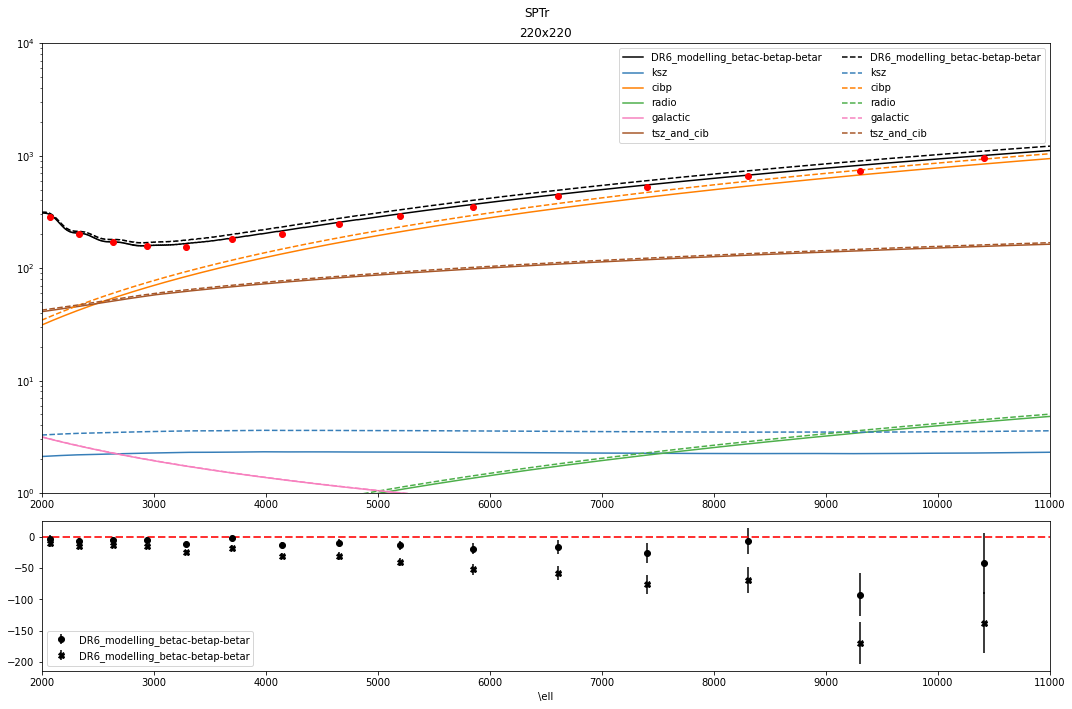

In [23]:
# Read data from files (replace these with your actual file paths)
ells_spt, dls_spt, err_spt = read_spt_bandpower_reichardt()
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0].errorbar(ells_spt[5], dls_spt[5], yerr=err_spt[5], fmt='o', c='r')

directory_list = ["DR6_modelling_betac-betap-betar/reichardt", "DR6_modelling_betac-betap-betar/MBAC_reichardt", 
                 ]
chain_list = ["reichardt", "MBAC_reichardt"]

for i_model in range(len(directory_list)):
    print(directory_list[i_model])
    label = directory_list[i_model].split('/')[0]
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory_list[i_model], chain_list[i_model])
    if i_model == 0 :
        cmp_list_freeze = cmp_list
    axs[0].plot(ell, DlsObs["tt", "sptr_220", "sptr_220"], c='k',label=label,ls=linestyle[i_model])
    for j_c, c in enumerate(cmp_list_freeze['sptr', 'tt']):
        axs[0].plot(ell, cmp["tt", "sptr_220", "sptr_220", c], ls=linestyle[i_model], c=col[j_c], label=c)
    axs[1].errorbar(ells_spt[5], dls_spt[5] - DlsObs_window["tt", "sptr_220", "sptr_220"], yerr=err_spt[5], fmt=fmt_list[i_model], c='k', label = label)

axs[0].legend(ncol=len(directory_list))
axs[1].legend()
axs[1].set_xlabel('\ell')
axs[0].set_yscale('log')
axs[1].plot([0,12000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
axs[0].set_ylim(1, 1e4)
axs[0].set_xlim(2000, 11000)
axs[1].set_xlim(2000, 11000)
axs[0].set_title(f"{freqs_spt[5]}")
    
plt.suptitle("SPTr")

plt.tight_layout()
plt.show()

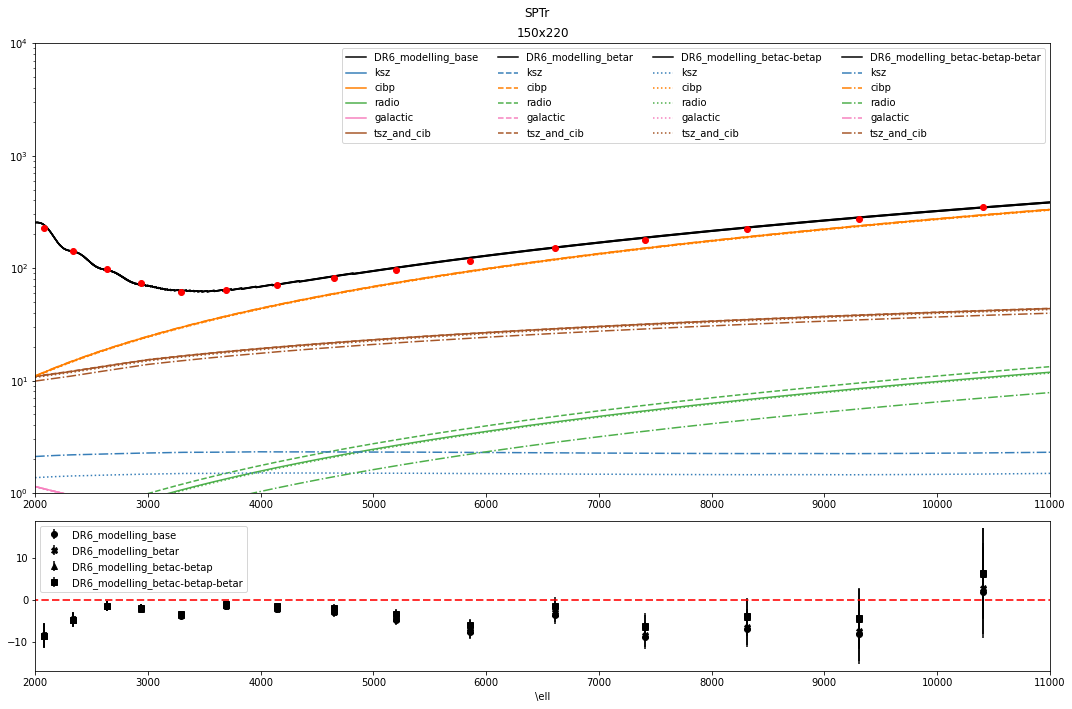

In [10]:
# Read data from files (replace these with your actual file paths)
ells_spt, dls_spt, err_spt = read_spt_bandpower_reichardt()
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot data
axs[0].errorbar(ells_spt[4], dls_spt[4], yerr=err_spt[4], fmt='o', c='r')

directory_list = ["DR6_modelling_base/reichardt", "DR6_modelling_betar/reichardt", 
                  "DR6_modelling_betac-betap/reichardt", "DR6_modelling_betac-betap-betar/reichardt"]
chain_list = ["reichardt", "reichardt", "reichardt", "reichardt"]

for i_model in range(len(directory_list)):
    label = directory_list[i_model].split('/')[0]
    ell, DlsObs,cmp,cmp_list,leff, DlsObs_window, chi_2 = get_dls_obs_highL(directory_list[i_model], chain_list[i_model])
    if i_model == 0 :
        cmp_list_freeze = cmp_list
    axs[0].plot(ell, DlsObs["tt", "sptr_150", "sptr_220"], c='k',label=label)
    for j_c, c in enumerate(cmp_list_freeze['sptr', 'tt']):
        axs[0].plot(ell, cmp["tt", "sptr_150", "sptr_220", c], ls=linestyle[i_model], c=col[j_c], label=c)
    axs[1].errorbar(ells_spt[4], dls_spt[4] - DlsObs_window["tt", "sptr_150", "sptr_220"], yerr=err_spt[4], fmt=fmt_list[i_model], c='k', label = label)

axs[0].legend(ncol=len(directory_list))
axs[1].legend()
axs[1].set_xlabel('\ell')
axs[0].set_yscale('log')
axs[1].plot([0,12000],[0,0], lw=2, ls = 'dashed', c='r', alpha=.8)
axs[0].set_ylim(1, 1e4)
axs[0].set_xlim(2000, 11000)
axs[1].set_xlim(2000, 11000)
axs[0].set_title(f"{freqs_spt[4]}")
    
plt.suptitle("SPTr")

plt.tight_layout()
plt.show()